# 第14章: CatBoostとカテゴリ変数の攻略

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] CatBoostの基本的な使い方を理解できる
- [ ] カテゴリ変数をOneHotEncodingなしで扱える
- [ ] 文字列データを直接モデルに入力できる
- [ ] CatBoostの可視化機能を活用できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 13（GBDT入門）
- ✅ Notebook 02（前処理・OneHotEncoding）

⏱️ **推定学習時間**: 60分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 機械学習・GBDT

---

## 🎯 CatBoostとは？

**CatBoost**（Categorical Boosting）は、Yandex（ロシアの検索エンジン会社）が開発したGBDTライブラリです。

### なぜカテゴリ変数が問題なのか？

機械学習モデルは基本的に**数値**しか扱えません。文字列データ（"Male", "Tokyo"など）をどうやって数値に変換するかが、常に課題でした。

```
┌─────────────────────────────────────────────────────────────────────┐
│                カテゴリ変数の「悩み」                                │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  元データ:                                                          │
│    ID | City    | Gender | Target                                   │
│    1  | Tokyo   | Male   | 1                                        │
│    2  | Osaka   | Female | 0                                        │
│    3  | Kyoto   | Male   | 1                                        │
│                                                                     │
│  問題: "Tokyo", "Male" などの文字列をどうやって数値化する？        │
│                                                                     │
│  【従来の方法】                                                     │
│                                                                     │
│  ① LabelEncoding: Tokyo=0, Osaka=1, Kyoto=2                        │
│     → 問題: 0 < 1 < 2 の大小関係が生まれてしまう                   │
│              （東京 < 大阪 < 京都？意味がない！）                   │
│                                                                     │
│  ② OneHotEncoding: Tokyo=[1,0,0], Osaka=[0,1,0], Kyoto=[0,0,1]    │
│     → 問題: カテゴリ数が多いと特徴量が爆発                         │
│              1000カテゴリ → 1000列に増加！                         │
│                                                                     │
│  ③ TargetEncoding: そのカテゴリの目的変数の平均値で置換           │
│     → 問題: データリークのリスク                                   │
│              過学習しやすい                                        │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### CatBoostの革新的な解決策

CatBoostは**Ordered Target Encoding**という独自の手法でこの問題を解決します：

```
┌─────────────────────────────────────────────────────────────────────┐
│              CatBoostの Ordered Target Encoding                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【従来の Target Encoding の問題】                                  │
│                                                                     │
│  全データを使って「Tokyo」の平均を計算:                             │
│    Tokyo の人: [1, 1, 0, 1] → 平均 = 0.75                          │
│    ↓                                                                │
│    Tokyo → 0.75 に置換                                             │
│                                                                     │
│  問題: 自分自身の答え（Target）を使っている！                       │
│        → テストデータでは使えない情報 = データリーク               │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【CatBoostの Ordered Target Encoding】                             │
│                                                                     │
│  各サンプルに対して、「それより前のサンプル」だけで平均を計算       │
│                                                                     │
│  データ順序: A → B → C → D                                        │
│                                                                     │
│  サンプルA（Tokyo）: 過去データなし → 事前確率（全体平均）を使用   │
│  サンプルB（Tokyo）: Aだけを参照 → Aの目的変数で計算               │
│  サンプルC（Osaka）: A,Bを参照 → 「Osaka」に該当するものだけ使う   │
│  サンプルD（Tokyo）: A,B,Cを参照 → A,BのうちTokyoの平均            │
│                                                                     │
│  → 各サンプルは「未来の情報」を見ない                               │
│  → データリークを完全に防止！                                       │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### CatBoostの3つの強み

| 特徴 | 説明 | 実務でのメリット |
|------|------|-----------------|
| **カテゴリ自動処理** | 文字列をそのまま入力可能 | 前処理コード削減 |
| **Ordered TS** | データリークを防ぐエンコーディング | 過学習を防止 |
| **デフォルトで高精度** | チューニングなしでも良い結果 | 素早いプロトタイピング |

---

In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# CatBoost
try:
    from catboost import CatBoostClassifier, Pool
    print("✅ CatBoost installed")
except ImportError:
    print("⚠️ CatBoost not installed. Run: pip install catboost")

# LightGBM and XGBoost for comparison
try:
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    print("✅ LightGBM and XGBoost available for comparison")
except ImportError:
    print("⚠️ Install LightGBM/XGBoost for full comparison")

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


✅ CatBoost installed
✅ LightGBM and XGBoost available for comparison


#### 📦 必要なライブラリの読み込み

**CatBoostのインストール**：
```bash
pip install catboost
```

CatBoostは他のGBDTライブラリと同様に、Scikit-learn互換のAPIを提供します。

## Part 1: カテゴリ変数を含むデータの作成

### 実世界のデータはカテゴリ変数だらけ

実務で扱うデータの多くは、カテゴリ変数を含んでいます：

```
┌─────────────────────────────────────────────────────────────────────┐
│                  カテゴリ変数の例                                    │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【EC・小売】                                                       │
│   - 商品カテゴリ: 家電、衣類、食品、書籍...                        │
│   - ブランド名: Nike、Adidas、Uniqlo...                            │
│   - 配送方法: 通常、速達、当日配送...                              │
│                                                                     │
│  【金融】                                                           │
│   - 職業: 会社員、自営業、公務員、学生...                          │
│   - 居住形態: 持ち家、賃貸、社宅...                                │
│   - 口座種別: 普通、当座、定期...                                  │
│                                                                     │
│  【マーケティング】                                                 │
│   - 流入経路: 検索、SNS、広告、直接...                             │
│   - デバイス: PC、スマホ、タブレット...                            │
│   - 地域: 都道府県、国...                                          │
│                                                                     │
│  【医療】                                                           │
│   - 診断コード: ICD-10（数万カテゴリ！）                           │
│   - 薬品名: 処方薬、市販薬...                                      │
│   - 症状: 発熱、頭痛、咳...                                        │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### カテゴリ変数の種類

| 種類 | 説明 | 例 | カテゴリ数 |
|------|------|-----|----------|
| **二値** | 2つの値 | 性別、Yes/No | 2 |
| **名義** | 順序なし | 都市名、職業 | 数十〜数千 |
| **順序** | 順序あり | 学歴、満足度 | 数個〜数十 |
| **高カーディナリティ** | 非常に多い | 郵便番号、商品ID | 数千〜数百万 |

**高カーディナリティ問題**：
カテゴリ数が多いと、OneHotEncodingで特徴量が爆発的に増加します。
CatBoostはこの問題を内部的に解決するため、高カーディナリティでも問題なく使えます。

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Create synthetic dataset with categorical features
np.random.seed(42)

n_samples = 1000

# Numerical features
age = np.random.randint(20, 70, n_samples)
income = np.random.randint(20000, 150000, n_samples)
credit_score = np.random.randint(300, 850, n_samples)

# Categorical features (文字列データ)
gender = np.random.choice(['Male', 'Female'], n_samples)
education = np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples)
city = np.random.choice(['Tokyo', 'Osaka', 'Kyoto', 'Fukuoka', 'Sapporo'], n_samples)
occupation = np.random.choice(['Engineer', 'Teacher', 'Doctor', 'Artist', 'Business'], n_samples)

# Target: Loan approval (based on features with some randomness)
loan_approved = (
    (income > 60000).astype(int) + 
    (credit_score > 650).astype(int) + 
    (age > 30).astype(int) +
    np.random.randint(0, 2, n_samples)
) >= 3

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'gender': gender,
    'education': education,
    'city': city,
    'occupation': occupation,
    'loan_approved': loan_approved.astype(int)
})

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nTarget distribution:")
print(df['loan_approved'].value_counts())

Dataset Overview:
Shape: (1000, 8)

First 5 rows:
   age  income  credit_score  gender    education     city occupation  \
0   58   48024           823    Male  High School    Osaka     Artist   
1   48   78656           594    Male          PhD    Osaka   Business   
2   34  136148           523    Male       Master    Kyoto     Artist   
3   62   47285           824  Female  High School  Fukuoka    Teacher   
4   27  112436           345    Male          PhD    Kyoto    Teacher   

   loan_approved  
0              1  
1              1  
2              1  
3              1  
4              0  

Data types:
age               int64
income            int64
credit_score      int64
gender           object
education        object
city             object
occupation       object
loan_approved     int64
dtype: object

Target distribution:
loan_approved
0    544
1    456
Name: count, dtype: int64


**データセットの説明**：

ローン承認を予測するデータセットを作成しました：

**数値特徴量**：
- age: 年齢
- income: 年収
- credit_score: 信用スコア

**カテゴリ特徴量（文字列）**：
- gender: 性別（Male/Female）
- education: 学歴（High School/Bachelor/Master/PhD）
- city: 都市（Tokyo/Osaka/Kyoto/Fukuoka/Sapporo）
- occupation: 職業（Engineer/Teacher/Doctor/Artist/Business）

通常、これらの文字列データはそのままモデルに入力できません。
しかし、**CatBoostなら可能**です！

## Part 2: 従来の方法 - OneHotEncodingが必要

### エンコーディング手法の比較

カテゴリ変数を数値化する方法は複数あります。それぞれの長所・短所を理解しましょう：

```
┌─────────────────────────────────────────────────────────────────────┐
│                    エンコーディング手法の比較                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【1. Label Encoding】                                              │
│                                                                     │
│  Tokyo → 0, Osaka → 1, Kyoto → 2                                   │
│                                                                     │
│  ✅ メリット: 特徴量数が増えない                                    │
│  ❌ デメリット: 順序関係が生まれる（Tokyo < Osaka?）                │
│  📝 用途: 決定木系（順序を気にしない）なら使える                    │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【2. OneHot Encoding】                                             │
│                                                                     │
│  Tokyo → [1, 0, 0]                                                 │
│  Osaka → [0, 1, 0]                                                 │
│  Kyoto → [0, 0, 1]                                                 │
│                                                                     │
│  ✅ メリット: 順序関係が生まれない                                  │
│  ❌ デメリット: 特徴量が爆発（1000カテゴリ → 1000列）              │
│  📝 用途: カテゴリ数が少ない場合（< 20程度）                       │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【3. Target Encoding (Mean Encoding)】                             │
│                                                                     │
│  Tokyo（平均Target=0.8）→ 0.8                                      │
│  Osaka（平均Target=0.3）→ 0.3                                      │
│                                                                     │
│  ✅ メリット: 特徴量数が増えない、目的変数との関係を捉える          │
│  ❌ デメリット: データリークのリスク、過学習しやすい                │
│  📝 用途: 慎重にCV内で実装する必要あり                             │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【4. CatBoostの Ordered Target Encoding】                          │
│                                                                     │
│  データ順序を考慮してTarget Encodingを適用                          │
│  各サンプルは「それより前のデータ」だけを参照                       │
│                                                                     │
│  ✅ メリット: データリークなし、過学習を防止、前処理不要            │
│  ❌ デメリット: CatBoost専用（他のライブラリでは使えない）          │
│  📝 用途: カテゴリ変数が多いデータセット                           │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### OneHotEncodingの具体的な問題

以下のコードで、OneHotEncodingによる特徴量の爆発を確認しましょう。

In [3]:
# ============================================================
# [コードの説明]
# ============================================================

# Traditional approach: OneHotEncoding
df_encoded = pd.get_dummies(df, columns=['gender', 'education', 'city', 'occupation'])

print("After OneHotEncoding:")
print(f"Original features: {df.shape[1]}")
print(f"Encoded features: {df_encoded.shape[1]}")
print(f"\nColumn names (first 20):")
print(list(df_encoded.columns[:20]))

After OneHotEncoding:
Original features: 8
Encoded features: 20

Column names (first 20):
['age', 'income', 'credit_score', 'loan_approved', 'gender_Female', 'gender_Male', 'education_Bachelor', 'education_High School', 'education_Master', 'education_PhD', 'city_Fukuoka', 'city_Kyoto', 'city_Osaka', 'city_Sapporo', 'city_Tokyo', 'occupation_Artist', 'occupation_Business', 'occupation_Doctor', 'occupation_Engineer', 'occupation_Teacher']


**OneHotEncodingの問題点**：

1. **特徴量が爆発的に増える**:
   - 元の8特徴量 → 25特徴量以上に増加
   - カテゴリ数が多いとさらに増える

2. **メモリ使用量が増加**:
   - スパース（ほとんど0）な行列を扱う

3. **前処理のコードが複雑化**:
   - 訓練データとテストデータで整合性を保つ必要
   - 新しいカテゴリへの対応が難しい

**CatBoostならこれらの問題を全て解決できます！**

In [4]:
# Train LightGBM with OneHotEncoded data
X_encoded = df_encoded.drop('loan_approved', axis=1)
y = df_encoded['loan_approved']

X_train_enc, X_test_enc, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

lgbm = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgbm.fit(X_train_enc, y_train)

print(f"LightGBM with OneHotEncoding:")
print(f"  Train Accuracy: {lgbm.score(X_train_enc, y_train):.4f}")
print(f"  Test Accuracy: {lgbm.score(X_test_enc, y_test):.4f}")
print(f"  Number of features: {X_encoded.shape[1]}")

LightGBM with OneHotEncoding:
  Train Accuracy: 1.0000
  Test Accuracy: 0.7450
  Number of features: 19


**従来の方法の結果**：

LightGBMは高精度ですが、前処理が必要でした。
次に、CatBoostで**同じデータを文字列のまま**使ってみます。

## Part 3: CatBoostの魔法 - 文字列のまま入力！

### CatBoostの内部処理を理解する

CatBoostがカテゴリ変数をどのように処理しているか、もう少し詳しく見てみましょう：

```
┌─────────────────────────────────────────────────────────────────────┐
│                CatBoostの内部処理フロー                              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  入力: X_train（文字列を含む）, y_train, cat_features               │
│                                                                     │
│  Step 1: データのシャッフルと順序付け                               │
│          ランダムな順序で並べ替え                                   │
│                                                                     │
│  Step 2: Ordered Target Statisticsの計算                            │
│          各サンプルi について:                                      │
│                                                                     │
│          TS_i = (Σ(過去のTarget) + prior × weight) /               │
│                 (過去のサンプル数 + weight)                         │
│                                                                     │
│          prior: 事前確率（全体の平均）                              │
│          weight: スムージングパラメータ                             │
│                                                                     │
│  Step 3: 決定木の学習                                               │
│          計算されたTS値を特徴量として使用                           │
│          通常のGBDTの学習を実行                                     │
│                                                                     │
│  Step 4: カテゴリの組み合わせも考慮                                 │
│          Gender × City のような組み合わせも自動で試す              │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### なぜ「文字列のまま」が重要なのか？

```
【従来のワークフロー】

1. データ読み込み
2. カテゴリ列を特定
3. エンコーダーを選択（OneHot? Label? Target?）
4. 訓練データでエンコーダーをfit
5. 訓練データをtransform
6. エンコーダーを保存（本番用）
7. テストデータをtransform
8. 新しいカテゴリへの対応を考える
9. モデル学習...

【CatBoostのワークフロー】

1. データ読み込み
2. cat_features を指定
3. モデル学習 ← これだけ！
```

### 使い方は驚くほどシンプル

In [5]:
# ============================================================
# [コードの説明]
# ============================================================

# Prepare data for CatBoost (NO ENCODING NEEDED!)
X = df.drop('loan_approved', axis=1)
y = df['loan_approved']

# Specify which columns are categorical
cat_features = ['gender', 'education', 'city', 'occupation']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data ready for CatBoost:")
print(f"\nTraining data (first 3 rows):")
print(X_train.head(3))
print(f"\nCategorical features: {cat_features}")
print(f"\nNotice: String values are kept as-is!")

Data ready for CatBoost:

Training data (first 3 rows):
     age  income  credit_score  gender education     city occupation
114   58   85441           724  Female       PhD  Fukuoka   Business
276   45   85310           484    Male    Master    Tokyo     Artist
422   47  148177           541  Female       PhD    Osaka    Teacher

Categorical features: ['gender', 'education', 'city', 'occupation']

Notice: String values are kept as-is!


**重要なポイント**：

- データは**元の形式のまま**（文字列を保持）
- `cat_features`でカテゴリ列を指定するだけ
- OneHotEncodingは**一切不要**

これだけで準備完了です！

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Train CatBoost
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)

# Fit with categorical features
catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,  # ← カテゴリ列を指定
    eval_set=(X_test, y_test),
    verbose=False
)

print(f"\nCatBoost with RAW categorical features:")
print(f"  Train Accuracy: {catboost_model.score(X_train, y_train):.4f}")
print(f"  Test Accuracy: {catboost_model.score(X_test, y_test):.4f}")
print(f"  Number of features: {X.shape[1]}")


CatBoost with RAW categorical features:
  Train Accuracy: 0.8675
  Test Accuracy: 0.7650
  Number of features: 7


**驚きの結果**：

- **前処理なし**で、LightGBM（OneHotEncoding版）と同等以上の精度
- 特徴量数は元のまま（8個）で、25個に膨らまない
- コードがシンプルで読みやすい

これがCatBoostの真価です！

## Part 4: 3つのGBDTライブラリを比較

### カテゴリ変数の扱いの違い

LightGBM、XGBoost、CatBoostはカテゴリ変数の扱いが異なります：

```
┌─────────────────────────────────────────────────────────────────────┐
│            GBDTライブラリのカテゴリ変数対応                         │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【LightGBM】                                                       │
│   - 文字列直接入力: ✗（LabelEncoding必要）                         │
│   - カテゴリ型サポート: ○（数値に変換後、categorical_feature指定） │
│   - 内部処理: 最適な分割点を探索（連続値扱い）                      │
│                                                                     │
│  【XGBoost】                                                        │
│   - 文字列直接入力: ✗（LabelEncoding必要）                         │
│   - カテゴリ型サポート: ○（v1.3以降、enable_categorical=True）     │
│   - 内部処理: 最適な分割点を探索                                    │
│                                                                     │
│  【CatBoost】                                                       │
│   - 文字列直接入力: ◎（そのまま入力可能！）                        │
│   - カテゴリ型サポート: ◎（最も充実）                              │
│   - 内部処理: Ordered Target Encoding                               │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### いつどのライブラリを使うべきか？

| 状況 | 推奨ライブラリ | 理由 |
|------|--------------|------|
| カテゴリ変数が多い | **CatBoost** | 前処理不要、自動最適化 |
| 高カーディナリティ | **CatBoost** | メモリ効率が良い |
| 速度が最優先 | **LightGBM** | 最も高速 |
| GPUで学習したい | **どれでも** | 全て対応 |
| 既存コードがある | **既存のもの** | 移行コスト |
| Kaggleで最高精度 | **全部試す** | アンサンブル |

### 公平な比較のための準備

In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# For fair comparison, use LabelEncoding for LightGBM/XGBoost
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_test_encoded[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Train all three models
models = {
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, random_seed=42, verbose=False)
}

results = []

for name, model in models.items():
    if name == 'CatBoost':
        # CatBoost: use original data with string categories
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)
    else:
        # LightGBM/XGBoost: use LabelEncoded data
        model.fit(X_train_encoded, y_train)
        train_acc = model.score(X_train_encoded, y_train)
        test_acc = model.score(X_test_encoded, y_test)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("GBDT Libraries Comparison with Categorical Features")
print("="*60)
print(df_results.to_string(index=False))


GBDT Libraries Comparison with Categorical Features
   Model  Train Accuracy  Test Accuracy
LightGBM            1.00          0.720
 XGBoost            1.00          0.715
CatBoost            0.84          0.760


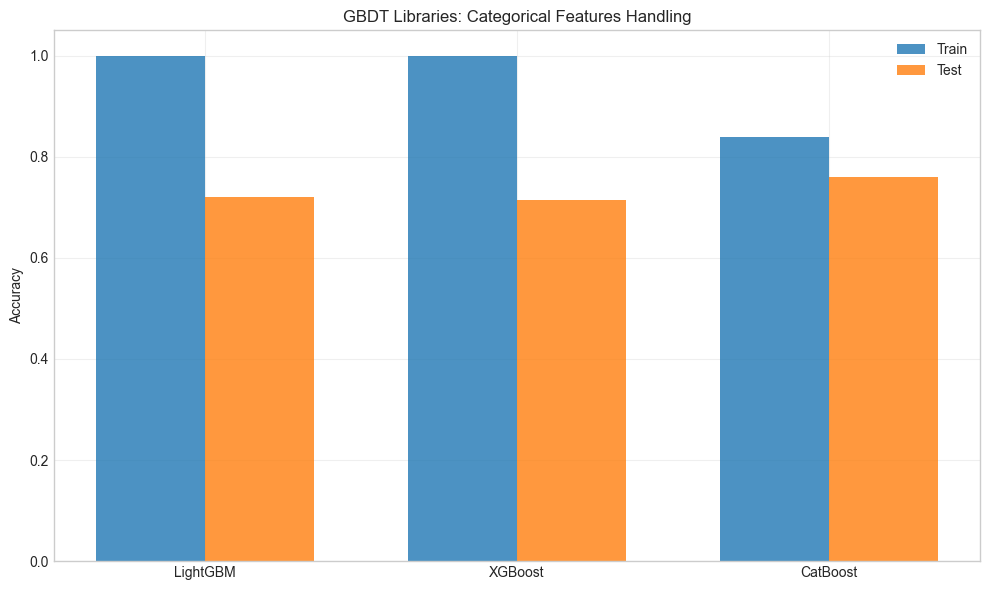

In [8]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_results))
width = 0.35

ax.bar(x - width/2, df_results['Train Accuracy'], width, label='Train', alpha=0.8)
ax.bar(x + width/2, df_results['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('GBDT Libraries: Categorical Features Handling')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Model'])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**比較結果の解釈**：

3つのライブラリすべてが高精度ですが、重要な違いがあります：

| ライブラリ | カテゴリ変数の扱い | 前処理の手間 |
|-----------|------------------|-------------|
| LightGBM  | LabelEncoding必要 | 中 |
| XGBoost   | LabelEncoding必要 | 中 |
| CatBoost  | 文字列のまま入力可 | **なし！** |

**CatBoostの優位性**：
- 前処理のコードを書く必要がない
- エンコーダーの保存・管理が不要
- 新しいカテゴリ値への対応が容易
- 可読性の高いモデル

## Part 5: CatBoostの可視化機能

### なぜ可視化が重要なのか？

モデルの可視化は、以下の目的で非常に重要です：

```
┌─────────────────────────────────────────────────────────────────────┐
│                    可視化の目的                                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【1. 過学習の検出】                                                │
│   - 学習曲線で訓練/検証の乖離を確認                                 │
│   - 早めに気づいて対策を打てる                                      │
│                                                                     │
│  【2. モデルの解釈】                                                │
│   - Feature Importanceで重要な特徴量を特定                         │
│   - ビジネス上の意思決定に活用                                      │
│                                                                     │
│  【3. デバッグ】                                                    │
│   - 予想外の挙動を発見                                              │
│   - データリークの検出                                              │
│                                                                     │
│  【4. コミュニケーション】                                          │
│   - 非技術者への説明                                                │
│   - レポート作成                                                    │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### CatBoostの可視化機能

CatBoostは他のライブラリより可視化機能が充実しています：

| 機能 | 説明 | 使い方 |
|------|------|--------|
| **学習曲線** | 訓練/検証の損失推移 | `evals_result_` |
| **Feature Importance** | 特徴量の重要度 | `get_feature_importance()` |
| **SHAP値** | 個別予測の説明 | `get_feature_importance(type='ShapValues')` |
| **木の可視化** | 決定木の構造 | `plot_tree()` |
| **対話的プロット** | Jupyter用 | `plot=True` |

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Train CatBoost with visualization
catboost_viz = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=False
)

catboost_viz.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=False  # Set to True for interactive plots in Jupyter
)

print("Model trained with learning curve tracking.")

Model trained with learning curve tracking.


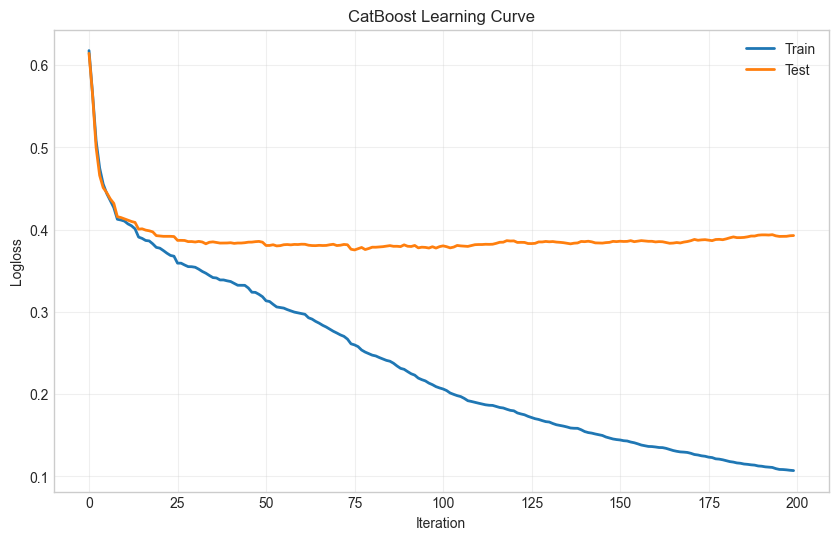


Best iteration: 75
Final test Logloss: 0.3926


In [10]:
# Get training history
train_errors = catboost_viz.evals_result_['learn']['Logloss']
test_errors = catboost_viz.evals_result_['validation']['Logloss']

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train', linewidth=2)
plt.plot(test_errors, label='Test', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBest iteration: {catboost_viz.get_best_iteration()}")
print(f"Final test Logloss: {test_errors[-1]:.4f}")

**学習曲線の読み方**：

- **訓練エラー（青線）**: 徐々に減少
- **テストエラー（オレンジ線）**: 最初は減少、後で横ばいか上昇
- **最適な反復回数**: テストエラーが最小の点

CatBoostは内部的にこの情報を保持しており、
`get_best_iteration()`で最適な反復回数を取得できます。

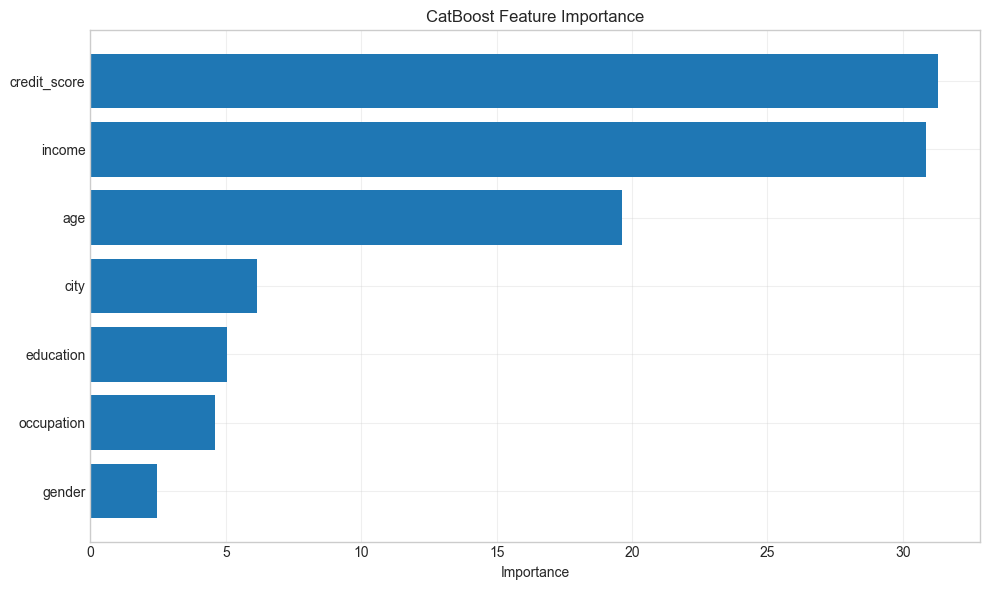


Feature Importance:
     feature  importance
credit_score   31.284778
      income   30.851839
         age   19.639461
        city    6.147870
   education    5.041461
  occupation    4.590483
      gender    2.444107


In [11]:
# Feature importance
feature_importance = catboost_viz.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(importance_df.to_string(index=False))

**Feature Importanceの解釈**：

カテゴリ特徴量も含めて、全ての特徴量の重要度が分かります。

この例では：
- **income（年収）**と**credit_score（信用スコア）**が最重要
- カテゴリ特徴量（education, occupationなど）も寄与している

重要度を見ることで、どの情報が予測に効いているか理解できます。

## Part 6: Poolオブジェクト - より効率的な方法

### Poolオブジェクトとは？

`Pool`はCatBoost専用のデータコンテナで、データとメタ情報を一緒に管理します。

```
┌─────────────────────────────────────────────────────────────────────┐
│                    Poolオブジェクトの構造                            │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  Pool オブジェクト                                                   │
│  ┌─────────────────────────────────────────────────────────────┐   │
│  │  data: 特徴量データ（DataFrame または numpy array）         │   │
│  │  label: 目的変数                                            │   │
│  │  cat_features: カテゴリ特徴量のインデックスまたは名前       │   │
│  │  text_features: テキスト特徴量（オプション）                │   │
│  │  weight: サンプルの重み（オプション）                       │   │
│  │  group_id: グループID（ランキング用、オプション）           │   │
│  │  feature_names: 特徴量の名前                                │   │
│  └─────────────────────────────────────────────────────────────┘   │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### Poolを使うメリット

```
【メリット1: コードの簡潔化】

# Poolを使わない場合（毎回cat_featuresを指定）
model.fit(X_train, y_train, cat_features=cat_features)
model.predict(X_test)  # ← cat_features指定不要だが...
model2.fit(X_train, y_train, cat_features=cat_features)  # また指定

# Poolを使う場合（一度だけ指定）
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)  # シンプル！
model2.fit(train_pool)  # 再利用可能！

【メリット2: メモリ効率】
- Poolは内部的に最適化された形式でデータを保持
- 大規模データでメモリ使用量が削減される
- 複数回の学習でデータの再変換が不要

【メリット3: 追加情報の管理】
- サンプルの重み（不均衡データ対策）
- グループID（ランキング学習）
- テキスト特徴量
```

### Poolの作成方法

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

# Create Pool objects
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

print("Pool objects created.")
print(f"Train pool: {train_pool.num_row()} samples")
print(f"Test pool: {test_pool.num_row()} samples")

Pool objects created.
Train pool: 800 samples
Test pool: 200 samples


**Poolオブジェクトとは？**

`Pool`は、CatBoost専用のデータコンテナです：

**メリット**：
1. カテゴリ特徴量の指定を一度だけ行えば良い
2. 内部的に最適化された形式でデータを保持
3. 大規模データでメモリ効率が良い
4. コードの見通しが良くなる

**いつ使う？**
- 同じデータで複数回学習する場合
- カテゴリ特徴量が多い場合
- メモリ使用量を抑えたい場合

In [13]:
# Train using Pool
catboost_pool = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

catboost_pool.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False
)

# Predict
y_pred = catboost_pool.predict(test_pool)
test_acc = accuracy_score(y_test, y_pred)

print(f"\nCatBoost with Pool:")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))


CatBoost with Pool:
  Test Accuracy: 0.7650

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       109
           1       0.75      0.73      0.74        91

    accuracy                           0.77       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.77      0.76       200



**Poolを使った結果**：

同じ精度が得られますが、コードがよりシンプルで読みやすくなりました。

**ベストプラクティス**：
```python
# カテゴリ特徴量が多い場合は、Poolを使うのがおすすめ
train_pool = Pool(X_train, y_train, cat_features=cat_features)
model.fit(train_pool)
```

## Part 7: CatBoostの実践的な使い方

### ハイパーパラメータ完全ガイド

CatBoostの主要なパラメータを理解して、モデルを最適化しましょう：

```
┌─────────────────────────────────────────────────────────────────────┐
│                CatBoostハイパーパラメータガイド                      │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【学習制御パラメータ】                                             │
│                                                                     │
│  iterations (n_estimators): 木の数                                  │
│    - デフォルト: 1000                                               │
│    - 推奨: Early Stoppingと組み合わせて大きめに設定                │
│                                                                     │
│  learning_rate: 学習率                                              │
│    - デフォルト: 自動調整                                           │
│    - 推奨: 0.03〜0.1（精度重視なら小さく）                         │
│                                                                     │
│  depth: 木の深さ                                                    │
│    - デフォルト: 6                                                  │
│    - 推奨: 4〜10（深いほど複雑、過学習リスク↑）                    │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【正則化パラメータ】                                               │
│                                                                     │
│  l2_leaf_reg: L2正則化                                              │
│    - デフォルト: 3                                                  │
│    - 推奨: 1〜10（大きいほど正則化強い）                           │
│                                                                     │
│  random_strength: ランダム性の強さ                                  │
│    - デフォルト: 1                                                  │
│    - 推奨: 過学習時に増やす                                        │
│                                                                     │
│  bagging_temperature: サンプリングの温度                            │
│    - デフォルト: 1                                                  │
│    - 推奨: 0〜1（0=決定的、1=ランダム）                            │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【カテゴリ変数パラメータ】                                         │
│                                                                     │
│  cat_features: カテゴリ特徴量のリスト                               │
│    - 列名のリスト or インデックスのリスト                          │
│                                                                     │
│  one_hot_max_size: OneHotに変換する最大カテゴリ数                  │
│    - デフォルト: 2                                                  │
│    - 推奨: 小さいカテゴリはOneHotの方が良い場合も                  │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### チューニングの優先順位

```
【チューニングの順序】

1. まずデフォルトで試す（CatBoostはデフォルトが優秀）
   ↓
2. Early Stoppingを設定
   ↓
3. learning_rateとiterationsのバランス調整
   ↓
4. depthの調整（過学習対策）
   ↓
5. 正則化パラメータの微調整
```

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Best practices for CatBoost
catboost_best = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,  # Regularization
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50  # Early stopping
)

catboost_best.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False
)

print(f"CatBoost with Best Practices:")
print(f"  Best iteration: {catboost_best.get_best_iteration()}")
print(f"  Total iterations: {catboost_best.tree_count_}")
print(f"  Test Accuracy: {catboost_best.score(X_test, y_test):.4f}")

CatBoost with Best Practices:
  Best iteration: 172
  Total iterations: 173
  Test Accuracy: 0.7500


**CatBoostのベストプラクティス**：

1. **Early Stopping**:
   - `early_stopping_rounds=50` で過学習を防ぐ
   - 検証データ（eval_set）を渡す

2. **正則化**:
   - `l2_leaf_reg` でL2正則化を適用
   - デフォルトでも良い値だが、調整可能

3. **学習率と反復回数**:
   - 学習率を小さく（0.03〜0.1）
   - 反復回数を多めに（Early Stoppingで自動停止）

4. **深さ**:
   - `depth=6` がデフォルトで良いバランス
   - データが少ない場合は4〜5に減らす

In [15]:
# Model comparison summary
models_final = {
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
    'CatBoost (Basic)': CatBoostClassifier(iterations=100, random_seed=42, verbose=False),
    'CatBoost (Tuned)': catboost_best
}

final_results = []

for name, model in models_final.items():
    if 'CatBoost' in name:
        if name == 'CatBoost (Tuned)':
            # Already trained
            test_acc = model.score(X_test, y_test)
        else:
            model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
            test_acc = model.score(X_test, y_test)
    else:
        model.fit(X_train_encoded, y_train)
        test_acc = model.score(X_test_encoded, y_test)
    
    final_results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'Preprocessing': 'LabelEncoding' if name in ['LightGBM', 'XGBoost'] else 'None'
    })

df_final = pd.DataFrame(final_results)
print("\n" + "="*70)
print("Final Model Comparison")
print("="*70)
print(df_final.to_string(index=False))


Final Model Comparison
           Model  Test Accuracy Preprocessing
        LightGBM          0.720 LabelEncoding
         XGBoost          0.715 LabelEncoding
CatBoost (Basic)          0.760          None
CatBoost (Tuned)          0.750          None


**最終比較の結論**：

1. **精度**: どのGBDTも高精度だが、チューニングで改善可能
2. **前処理**: CatBoostは前処理が不要で圧倒的に楽
3. **実務での選択**:
   - カテゴリ変数が多い → **CatBoost**
   - 速度優先 → **LightGBM**
   - 安定性重視 → **XGBoost**
   - 最高精度 → **全て試してアンサンブル**

## まとめ

### 🎯 このノートブックで学んだこと

```
┌─────────────────────────────────────────────────────────────────────┐
│              CatBoost & カテゴリ変数 完全マスターマップ              │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ① カテゴリ変数の課題                                               │
│     └── Label Encoding: 偽の順序関係                                │
│     └── OneHot Encoding: 特徴量爆発                                 │
│     └── Target Encoding: データリークリスク                         │
│                                                                     │
│  ② CatBoostの解決策                                                 │
│     └── Ordered Target Encoding: データリーク防止                   │
│     └── 文字列直接入力: 前処理不要                                  │
│     └── 自動組み合わせ: カテゴリの交互作用も考慮                    │
│                                                                     │
│  ③ 実践的な使い方                                                   │
│     └── cat_features の指定                                         │
│     └── Poolオブジェクトの活用                                      │
│     └── Early Stopping & 可視化                                     │
│                                                                     │
│  ④ ライブラリ選択                                                   │
│     └── CatBoost: カテゴリ変数が多い場合                            │
│     └── LightGBM: 速度重視                                          │
│     └── XGBoost: 安定性重視                                         │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

---

### 📋 CatBoostクイックリファレンス

#### 基本テンプレート（シンプル版）

```python
from catboost import CatBoostClassifier

# カテゴリ列を指定
cat_features = ['gender', 'education', 'city']

# モデル作成
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=100
)

# 学習（文字列データをそのまま入力！）
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)
```

#### 本番用テンプレート（Pool使用版）

```python
from catboost import CatBoostClassifier, Pool

# Poolオブジェクトでデータを管理
cat_features = ['gender', 'education', 'city']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

# モデル作成（本番用設定）
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    early_stopping_rounds=100,
    verbose=False
)

# 学習
model.fit(train_pool, eval_set=val_pool)

# 予測
predictions = model.predict(test_pool)
probabilities = model.predict_proba(test_pool)
```

---

### 🔧 エンコーディング手法早見表

| 手法 | 特徴量数 | データリーク | 順序関係 | おすすめ場面 |
|------|---------|-------------|---------|-------------|
| Label | 増えない | なし | あり（問題） | 決定木系のみ |
| OneHot | 爆発 | なし | なし | カテゴリ少ない |
| Target | 増えない | あり（要注意） | なし | CV内で慎重に |
| **CatBoost** | 増えない | なし | なし | **常に推奨** |

---

### ✅ CatBoostチェックリスト

#### データ準備
- [ ] カテゴリ列の特定（object型の列）
- [ ] cat_featuresリストの作成
- [ ] 欠損値の確認（CatBoostは欠損値も扱える）

#### モデル設定
- [ ] Early Stoppingの設定
- [ ] 検証データ（eval_set）の準備
- [ ] 適切なiterations/learning_rateの設定

#### 評価・分析
- [ ] 学習曲線の確認（過学習チェック）
- [ ] Feature Importanceの確認
- [ ] 他のGBDTライブラリとの比較

---

### 🔄 GBDTライブラリ選択フローチャート

```
カテゴリ変数が多い？
    │
    ├── Yes → CatBoost（前処理不要）
    │
    └── No → 速度が最優先？
              │
              ├── Yes → LightGBM（最速）
              │
              └── No → XGBoost（安定）
              
※ 最高精度を求めるなら → 全部試してアンサンブル！
```

---

### 🚀 次のステップ

**Notebook 15: 実践！タイタニック - EDA & 特徴量エンジニアリング** では：
- 実際のKaggleデータセットに挑戦
- EDA（探索的データ分析）の実践
- 学んだGBDTの知識を活用

**さらに学ぶために**：
- SHAP値によるモデル解釈
- Optunaによるハイパーパラメータ最適化
- CatBoostのGPU学習

---

### 🎉 お疲れ様でした！

カテゴリ変数の扱いは実務で最も頻繁に直面する課題です。
CatBoostをマスターすれば、この課題を簡単に解決できます！

### ⚠️ よくあるエラー #1: カテゴリ列の指定忘れ

カテゴリ変数を指定しないと、CatBoostは数値として扱ってしまいます。

**原因:**
1. `cat_features`パラメータを渡していない
2. カテゴリ列の名前を間違えている

**✅ 解決法:**

```python
# ❌ 間違い: cat_featuresを指定しない
model.fit(X_train, y_train)

# ✅ 正しい: cat_featuresを明示的に指定
cat_features = ['gender', 'education', 'city']
model.fit(X_train, y_train, cat_features=cat_features)

# または列のインデックスで指定
cat_features = [3, 4, 5]  # 列番号
model.fit(X_train, y_train, cat_features=cat_features)
```

---

### ⚠️ よくあるエラー #2: 訓練データにない新しいカテゴリ

テストデータに訓練データで見たことのないカテゴリ値が現れるとエラーになります。

**原因:**
1. データ分割が不適切
2. レアなカテゴリが存在する

**✅ 解決法:**

```python
# 方法1: stratifyでバランスを保つ
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 方法2: CatBoostの自動処理機能を使う
model = CatBoostClassifier(
    iterations=100,
    random_seed=42,
    nan_mode='Min'  # 未知のカテゴリを特別な値として扱う
)
```

---

---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: CatBoostの最大の利点は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: カテゴリ変数を文字列のまま直接入力できること

CatBoostは、"Male"や"Female"のような文字列データをOneHotEncodingやLabelEncodingなしで扱えます。これにより、前処理のコードが劇的に減り、特徴量の数も爆発的に増えません。実務では、この手間の削減が非常に大きな価値を持ちます。

</details>

---

### Q2: Poolオブジェクトを使うメリットは何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: カテゴリ特徴量の指定を一度だけ行えば良く、メモリ効率が良い

Poolオブジェクトは、データとカテゴリ特徴量の情報を一緒に保持します。これにより、`fit()`や`predict()`のたびに`cat_features`を指定する必要がなくなります。また、CatBoost内部で最適化された形式でデータを保持するため、大規模データでメモリ効率が向上します。

</details>

---

### Q3: LightGBM、XGBoost、CatBoostの使い分けは？

<details>
<summary>💡 答えを見る</summary>

**答え**: データの特性と優先事項によって選択する

- **CatBoost**: カテゴリ変数が多い場合、前処理を減らしたい場合
- **LightGBM**: 速度が最優先、大規模データを扱う場合
- **XGBoost**: 安定性重視、歴史が長く実績がある

実務やKaggleでは、全て試して最も良い結果を選ぶか、アンサンブルで組み合わせるのがベストプラクティスです。

</details>

---

</details>

---

## ➡️ 次のステップ

### 学習を続ける

次は **Notebook 15: 実践！タイタニック - EDA & 特徴量エンジニアリング** へ進みましょう！

いよいよKaggleの有名なタイタニックデータセットに挑戦します。
学んだGBDTの知識を実際のデータで活用しましょう！

### 復習が必要な場合

- **Notebook 13: GBDT入門**
- **Notebook 02: 前処理とFeature Engineering**

### さらに学ぶために

**公式ドキュメント:**
- CatBoost: https://catboost.ai/docs/

**チュートリアル:**
- CatBoost Tutorial: https://github.com/catboost/tutorials

**Kaggleで実践:**
- Titanic Competition（次章で挑戦！）

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！